# Analyzing Timelags through Different Classifier Methods

In [1]:
import numpy as np
from scipy.interpolate import splev,splprep
import matplotlib
import matplotlib.pyplot as plt
from sunpy.map import Map
from sunpy.coordinates import HeliographicStonyhurst
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from distributed import Client
#from dask_ml.model_selection import GridSearchCV

import synthesizAR

%matplotlib inline

In this notebook, we want to analyze our observed timelags using our modeled timelags for our three primary heating scenarios along with a multi-classification classifier, e.g. random forest.

We'll do this in a few stages:
* Import simulation data
* Clean and prep simulation data
* Train a model on simulation data
* Import, clean, prep observed data
* Classify observed data based on above model
* Create map of heating frequencies from our classified observed data

In [56]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

## Import and Prep Simulation Data

First, let's import the simulation data.

In [3]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [4]:
frequencies = ['high', 'intermediate', 'low']

In [5]:
filename = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}_frequency/nei/timelags/{type}_{c0}_{c1}.fits'

In [6]:
timelag,correlation = {}, {}
for f in frequencies:
    timelag[f'{f}'] = {}
    correlation[f'{f}'] = {}
    for p in channel_pairs:
        timelag[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='timelag', c0=p[0], c1=p[1]))
        correlation[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='correlation', c0=p[0], c1=p[1]))

Now that we've got the data, we need to transform it into a format that the model framework, scikit-learn, can understand.

We need a matrix $\mathbf{X}$ with dimensions $N_{samples}\times N_{features}$. In our case, $N_{samples}$ is just the total number of pixels and $N_{features}$ is the number of channel pairs, i.e. $N_{features}=6$. Each entry in $\mathbf{X}$ will give the (scaled) timelag value for that particular channel pair at a single pixel. Additionally, we need another matrix $\mathbf{Y}$ which gives the heating classification for each pixel. We can encode the heating frequency in the following way,

| Heating Frequency | Encoding |
|-------------------|----------|
| Low | 2 |
| Intermediate | 1 |
| High | 0 |

To summarize, we need to construct two matrices from our imported simulation data,

$$
\mathbf{X} \in \mathbb{R}^{N_{samples}\times N_{features}} \\ 
\mathbf{Y} \in \mathbb{R}^{N_{samples}}
$$

Furthermore, we want to filter our timelag values so as to exclude those pixels with low correlations.

Now, we are ready to create $\mathbf{X}$ and $\mathbf{Y}$.

In [7]:
X = None
Y = None
correlation_threshold = 500.0
for f in frequencies:
    X_tmp = None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([correlation[f]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) > correlation_threshold,axis=2)
    i_accept = np.where(acceptable)
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = timelag[f]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X = X_tmp.copy() if X is None else np.vstack([X, X_tmp])
    Y_tmp = np.array(X_tmp.shape[0]*[f])
    Y = Y_tmp.copy() if Y is None else np.concatenate([Y, Y_tmp])

We need to "encode" $\mathbf{Y}$. The first step is to go from our string label ("high", "intermediate", "low) to a numerical label (0, 1, 2). The second step is to encode our single category (heating frequency) as either on/off in three different categories. Notice that this means that $\mathbf{Y}$ now has dimensions
$\mathbf{Y}\in\mathbb{R}^{N_{samples}\times~3}$ since we our heating frequency can take on three different possible values.

In [8]:
le = LabelEncoder()
le.fit(['high','intermediate','low'])
Y_encoded = le.transform(Y)

Next, we need to scale our data. scikit-learn provides convenient machinery for doing this. Notice that we do not scale $\mathbf{Y}$ as it is a categorical variable.

In [9]:
X_scaled = scale(X, axis=0, with_mean=True, with_std=True,)

Finally, we want to split our inputs into training and test sets in order to properly assess our model performance.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.33)

Encade after splitting because some classifiers require flattened $\mathbf{Y}$ while others need it to be multidimensional.

In [ ]:
## Dont think this is actually necessary ##
#ohe = OneHotEncoder()
#ohe.fit([[0],[1],[2]])
#Y_train_multi = ohe.transform(Y_train_flat.reshape(Y_train_flat.shape[0],1)).toarray()
#Y_test_multi = ohe.transform(Y_test_flat.reshape(Y_test_flat.shape[0],1)).toarray()

Basically what we've done here is convert a string representation (e.g. "high") to a numerical representation (e.g. 0) to a multidimensional binary representation (e.g. $[1,0,0]$). Thus, the transformation is as follows,

$$
\begin{pmatrix}
\text{high} \\ \text{intermediate} \\ \text{low}
\end{pmatrix}
\to
\begin{pmatrix}
0\\1\\2
\end{pmatrix}
\to
\begin{pmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{pmatrix}
$$
Note that the intermediate encoding doesn't really matter. Only that the map between the initial and final steps is consistent.

## Import and Prep Observational Data
Our observational data import and prep process is essentially the same as that of the simulation data. Here, we also want to save the pixel locations of all the timelag values so that we can reconstruct the map later on.

First, we need to get the locations of all of our loops in terms of the observed maps. This is so that we can mask our observed maps according to the area of the AR that we actually simulated. Since the model is trained only on the simulated data, we cannot really apply that model to an area of the AR that we did not simulate. This is especially true in areas of open field.

In [11]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [12]:
ds = 0.5*u.Mm
stacked_coords = None
for loop in field.loops:
    knots, _ = splprep(loop.coordinates.cartesian.xyz.value)
    n_interp = int(np.ceil((loop.full_length/ds).decompose()))
    tmp = np.array(splev(np.linspace(0, 1, n_interp), knots))
    if stacked_coords is None:
        stacked_coords = tmp
    else:
        stacked_coords = np.hstack([stacked_coords, tmp])
stacked_coords = u.Quantity(stacked_coords, loop.coordinates.cartesian.xyz.unit)
stacked_coords = SkyCoord(x=stacked_coords[0,:],y=stacked_coords[1,:],z=stacked_coords[2,:],frame=HeliographicStonyhurst,representation='cartesian')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [13]:
sample_obs_map = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/timelag_171_131.fits')

In [14]:
core_pixels = sample_obs_map.world_to_pixel(stacked_coords.transform_to(HeliographicStonyhurst).transform_to(sample_obs_map.coordinate_frame))

In [15]:
x_pixel_mask = core_pixels.x.value.round().astype(int)
y_pixel_mask = core_pixels.y.value.round().astype(int)
i_inbounds = np.where(np.logical_and(x_pixel_mask>=0, y_pixel_mask>=0))
x_pixel_mask = x_pixel_mask[i_inbounds]
y_pixel_mask = y_pixel_mask[i_inbounds]

Next, import all of the data

In [16]:
filename = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{type}_{c0}_{c1}.fits'
timelag_obs = {}
correlation_obs = {}
for p in channel_pairs:
    timelag_obs['{}_{}'.format(*p)] = Map(filename.format(type='timelag', c0=p[0], c1=p[1]))
    correlation_obs['{}_{}'.format(*p)] = Map(filename.format(type='correlation', c0=p[0], c1=p[1]))

Finally, flatten the data and apply the mask of the simulated area.

In [17]:
X_observation = None
# Find the indices where all channel pairs have an acceptable correlation
acceptable_correlation = np.all(np.stack([correlation_obs['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) > correlation_threshold,axis=2)
# Mark those indices outside of the mask as false
acceptable_ar_mask = False*np.ones(acceptable_correlation.shape,dtype=bool)
acceptable_ar_mask[y_pixel_mask,x_pixel_mask] = True
# Combine two criteria
acceptable = np.all(np.stack([acceptable_correlation, acceptable_ar_mask],axis=2),axis=2)
i_accept_obs = np.where(acceptable)
for p in channel_pairs:
    # Read in timelags and correlations
    tmp_tl = timelag_obs['{}_{}'.format(*p)].data
    # Only keep those timelags with sufficiently high correlations
    tmp_tl = tmp_tl[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation = tmp_tl.copy()[:,np.newaxis] if X_observation is None else np.hstack([X_observation, tmp_tl[:, np.newaxis]])

And scale the data appropriately

In [18]:
X_observation = scale(X_observation, axis=0, with_mean=True, with_std=True)

## Training and Assessing the Models
We've prepped our data appropriately and we're finally ready to train our models and assess their performance. We'll also apply each model to our observational data. We'll build a model from our data for each of the following methods:

* Decision Tree
* Random Forest
* Adaptively-boosted Decision Trees (Adaboost)
* $K$-nearest Neighbors

### Decision Tree

In [19]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features='sqrt')
clf.fit(X_train, Y_train)
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Test error = 0.11744890576957856


In [20]:
Y_observation = clf.predict(X_observation)

In [21]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_decision_tree = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_decision_tree = frequency_map_decision_tree.submap(
    frequency_map_decision_tree.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_decision_tree.coordinate_frame)
)

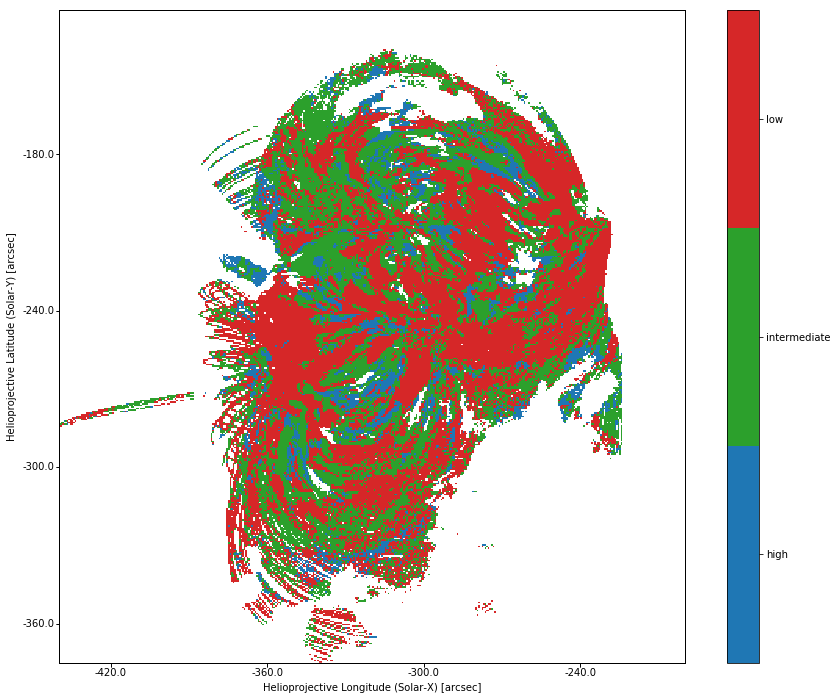

In [22]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_decision_tree)
im = frequency_map_decision_tree.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

### Random Forest

In [66]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=25,bootstrap=True,)
clf.fit(X_train,Y_train)
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Test error = 0.04495614035087714


/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


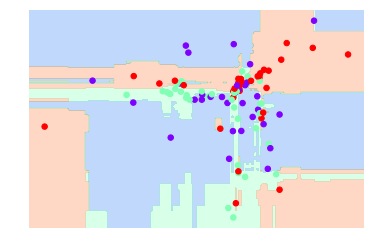

In [75]:
visualize_classifier(RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=25,bootstrap=True,),
                     X_train[:100,0:2],Y_train[:100],)

We can assess these parameters one by one or we can perform a grid search over all of the parameters that can be tuned for the random forest estimator. This is a bit more thorough and we can use Dask to scale out across all available cores.

In [ ]:
grid_params = {
    'n_estimators': [10,50,200],
    'criterion': ['gini','entropy'],
    'max_depth': [2, 25],
    'bootstrap': [True, False]
}

In [ ]:
#client = Client()

In [ ]:
#client

In [ ]:
rf = RandomForestClassifier()
clf = GridSearchCV(rf, grid_params,n_jobs=-1,)

In [ ]:
clf.fit(X_train,Y_train)

In [ ]:
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Now, apply our trained model to the observed dataset.

In [76]:
Y_observation = clf.predict(X_observation)

In [77]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_random_forest = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_random_forest = frequency_map_random_forest.submap(
    frequency_map_random_forest.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_random_forest.coordinate_frame)
)

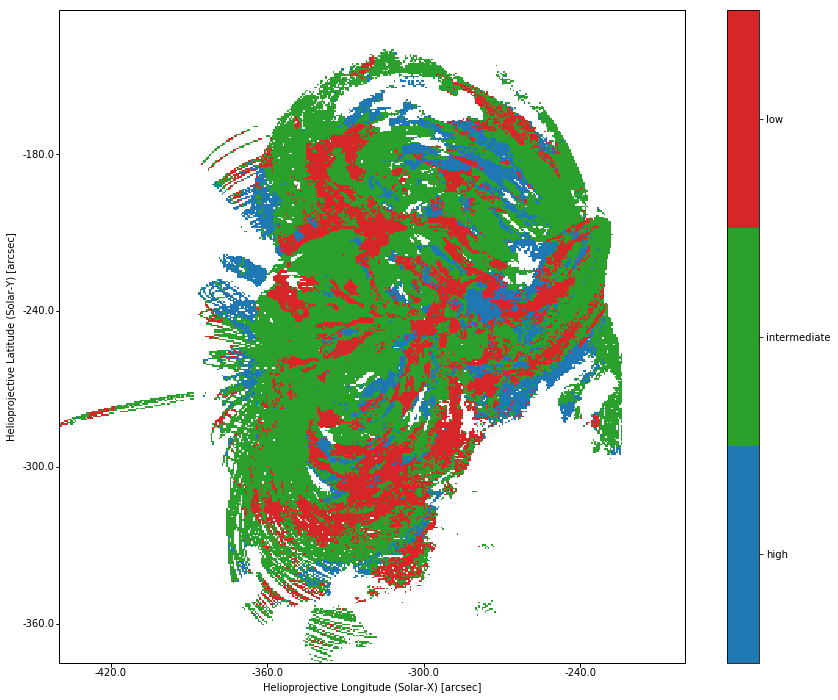

In [78]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_random_forest)
im = frequency_map_random_forest.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

In [79]:
Y_observation_prob = clf.predict_proba(X_observation)

In [80]:
# High
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,0]
frequency_map_random_forest_prob_hf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_random_forest_prob_hf = frequency_map_random_forest_prob_hf.submap(
    frequency_map_random_forest_prob_hf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_random_forest_prob_hf.coordinate_frame)
)
# Intermediate
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,1]
frequency_map_random_forest_prob_if = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_random_forest_prob_if = frequency_map_random_forest_prob_if.submap(
    frequency_map_random_forest_prob_if.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_random_forest_prob_if.coordinate_frame)
)
# Low
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,2]
frequency_map_random_forest_prob_lf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_random_forest_prob_lf = frequency_map_random_forest_prob_lf.submap(
    frequency_map_random_forest_prob_lf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_random_forest_prob_lf.coordinate_frame)
)

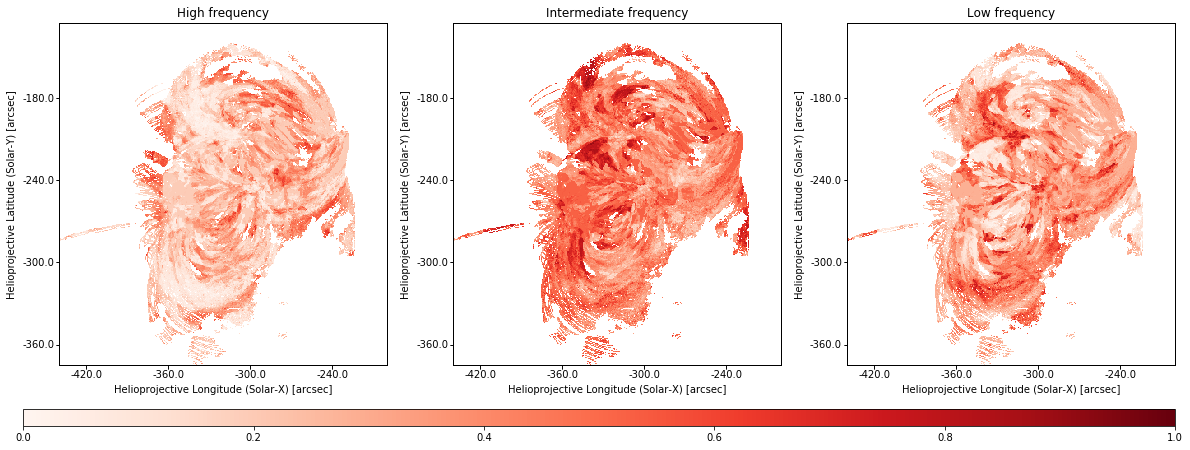

In [81]:
fig = plt.figure(figsize=(20,8))
cax = fig.add_axes((0.1,0.1,0.8,0.03))
map_args = {'title':False,'cmap':'Reds','vmin':0,'vmax':1}
ax = fig.add_subplot(131,projection=frequency_map_random_forest_prob_hf)
ax.set_title('High frequency')
im = frequency_map_random_forest_prob_hf.plot(
    axes=ax,**map_args)
ax.grid(alpha=0)
ax = fig.add_subplot(132,projection=frequency_map_random_forest_prob_if)
ax.set_title('Intermediate frequency')
im = frequency_map_random_forest_prob_if.plot(
    axes=ax,**map_args)
ax.grid(alpha=0)
ax = fig.add_subplot(133,projection=frequency_map_random_forest_prob_lf)
ax.set_title('Low frequency')
im = frequency_map_random_forest_prob_lf.plot(
    axes=ax,**map_args)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax,cax=cax,orientation='horizontal')

### Adaboost

In [32]:
clf = AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=25),
                learning_rate=1.0,
                n_estimators=100,
)
clf.fit(X_train, Y_train)
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Test error = 0.07241363718574789


In [33]:
Y_observation = clf.predict(X_observation)

In [34]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_adaboost = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_adaboost = frequency_map_adaboost.submap(
    frequency_map_adaboost.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_adaboost.coordinate_frame)
)

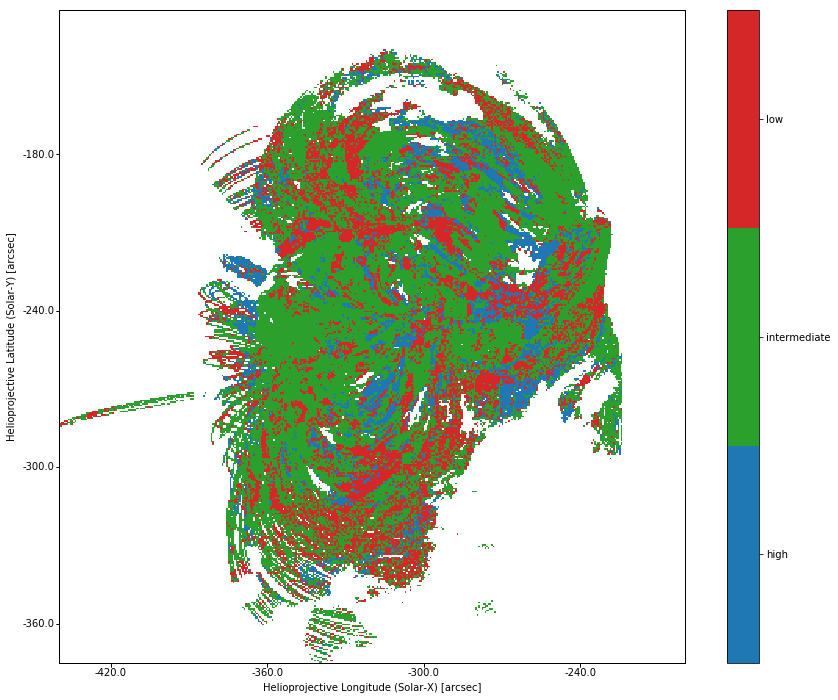

In [35]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_adaboost)
im = frequency_map_adaboost.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

In [36]:
Y_observation_prob = clf.predict_proba(X_observation)

In [37]:
# High
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,0]
frequency_map_prob_hf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_hf = frequency_map_prob_hf.submap(
    frequency_map_prob_hf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_hf.coordinate_frame)
)
# Intermediate
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,1]
frequency_map_prob_if = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_if = frequency_map_prob_if.submap(
    frequency_map_prob_if.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_if.coordinate_frame)
)
# Low
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,2]
frequency_map_prob_lf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_lf = frequency_map_prob_lf.submap(
    frequency_map_prob_lf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_lf.coordinate_frame)
)

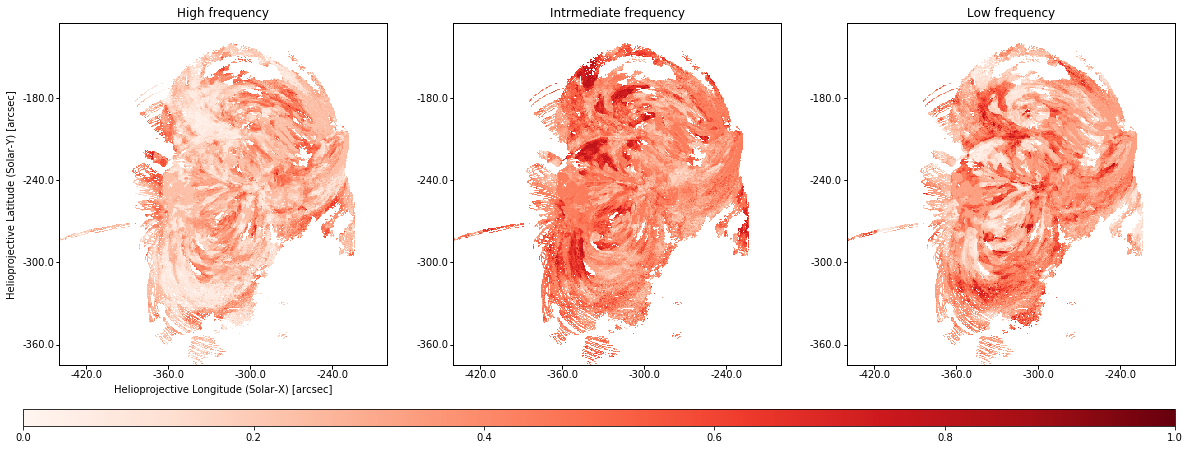

In [38]:
fig = plt.figure(figsize=(20,8))
cax = fig.add_axes((0.1,0.1,0.8,0.03))
cmap = plt.get_cmap('Reds')
map_args = {'title':False,'cmap':cmap,'vmin':0.,'vmax':1}
ax = fig.add_subplot(131,projection=frequency_map_random_forest_prob_hf)
ax.set_title('High frequency')
im = frequency_map_random_forest_prob_hf.plot(
    axes=ax,**map_args)
ax.grid(alpha=0)
ax = fig.add_subplot(132,projection=frequency_map_random_forest_prob_if)
ax.set_title('Intrmediate frequency')
im = frequency_map_random_forest_prob_if.plot(axes=ax,**map_args,annotate=False)
ax.grid(alpha=0)
ax = fig.add_subplot(133,projection=frequency_map_random_forest_prob_lf)
ax.set_title('Low frequency')
im = frequency_map_random_forest_prob_lf.plot(axes=ax,**map_args,annotate=False)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax,cax=cax,orientation='horizontal')

### Gradient Boosting

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.,max_depth=25,)

In [ ]:
clf.fit(X_train,Y_train_flat)

In [ ]:
print(f'Test error = {1. - clf.score(X_test,Y_test_flat)}')

In [ ]:
Y_observation = clf.predict(X_observation_scaled)

In [ ]:
#HACK: reverse encoding to be consistent with other models
_tmp = np.empty(Y_observation.shape)
_tmp[np.where(Y_observation == 0)] = 2
_tmp[np.where(Y_observation == 1)] = 1
_tmp[np.where(Y_observation == 2)] = 0
Y_observation = _tmp

In [ ]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_gradboost = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_gradboost = frequency_map_gradboost.submap(
    frequency_map_gradboost.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_gradboost.coordinate_frame)
)

### $K$ Nearest Neighbors 

In [39]:
clf = KNeighborsClassifier(2, weights='distance',n_jobs=-1,)
clf.fit(X_train,Y_train)
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Test error = 0.09907985169108335


In [40]:
Y_observation = clf.predict(X_observation)

In [43]:
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation
frequency_map_knn = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_knn = frequency_map_knn.submap(
    frequency_map_knn.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_knn.coordinate_frame)
)

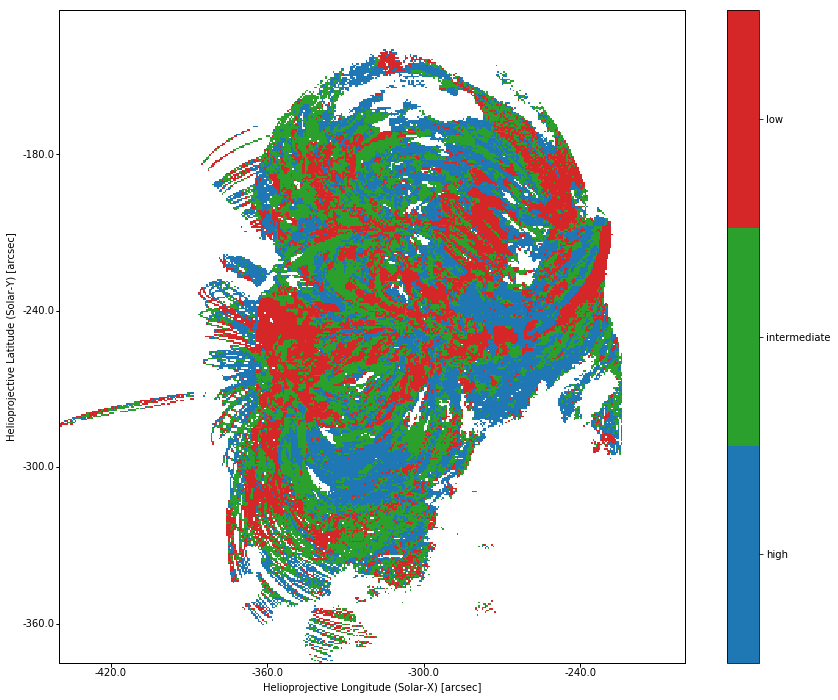

In [44]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection=frequency_map_knn)
im = frequency_map_knn.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),
    vmin=-0.5,vmax=2.5)
fig.colorbar(im, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
ax.grid(alpha=0)

In [45]:
Y_observation_prob = clf.predict_proba(X_observation)

In [46]:
# High
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,0]
frequency_map_prob_hf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_hf = frequency_map_prob_hf.submap(
    frequency_map_prob_hf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_hf.coordinate_frame)
)
# Intermediate
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,1]
frequency_map_prob_if = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_if = frequency_map_prob_if.submap(
    frequency_map_prob_if.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_if.coordinate_frame)
)
# Low
map_data = np.nan*timelag_obs['{}_{}'.format(*channel_pairs[0])].data
map_data[i_accept_obs] = Y_observation_prob[:,2]
frequency_map_prob_lf = Map(map_data, timelag_obs['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map_prob_lf = frequency_map_prob_lf.submap(
    frequency_map_prob_lf.bottom_left_coord,
    SkyCoord(-200*u.arcsec,-125*u.arcsec,frame=frequency_map_prob_lf.coordinate_frame)
)

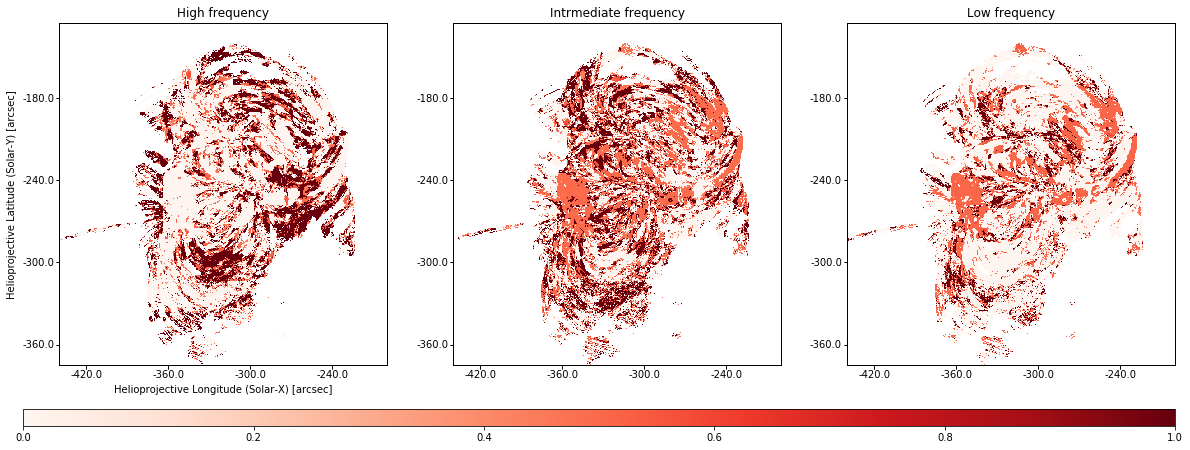

In [48]:
fig = plt.figure(figsize=(20,8))
cax = fig.add_axes((0.1,0.1,0.8,0.03))
map_args = {'title':False,'cmap':'Reds','vmin':0.,'vmax':1}
ax = fig.add_subplot(131,projection=frequency_map_prob_hf)
ax.set_title('High frequency')
im = frequency_map_prob_hf.plot(
    axes=ax,**map_args)
ax.grid(alpha=0)
ax = fig.add_subplot(132,projection=frequency_map_prob_if)
ax.set_title('Intrmediate frequency')
im = frequency_map_prob_if.plot(axes=ax,**map_args,annotate=False)
ax.grid(alpha=0)
ax = fig.add_subplot(133,projection=frequency_map_prob_lf)
ax.set_title('Low frequency')
im = frequency_map_prob_lf.plot(axes=ax,**map_args,annotate=False)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax,cax=cax,orientation='horizontal')

### Neural Network
Train a neural network with Keras.

## Comparing Methods

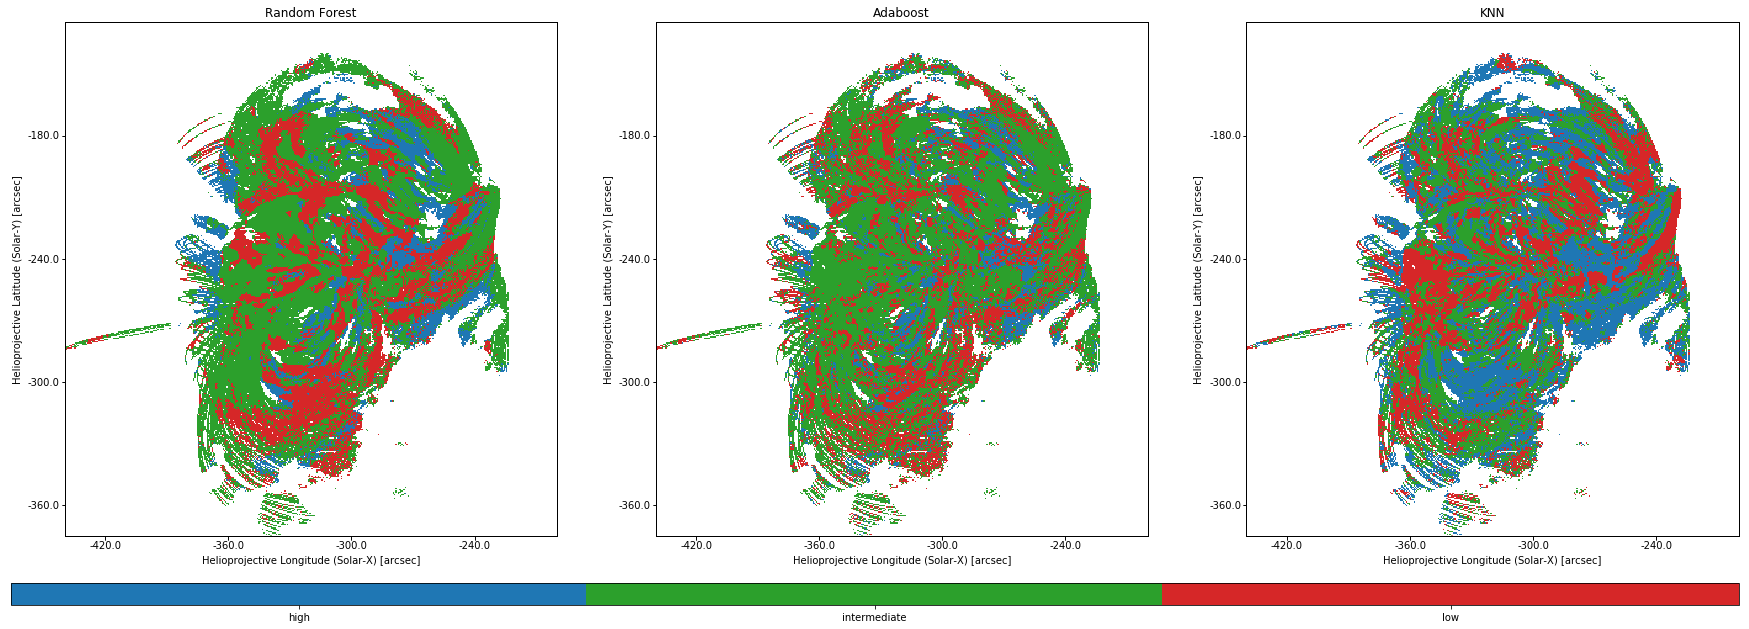

In [52]:
fig = plt.figure(figsize=(30,10))
cax = fig.add_axes((0.1,0.05,0.8,0.03))
plot_args = {'cmap': matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3),'vmin':-0.5,'vmax':2.5}
# Random Forest
ax = fig.add_subplot(1,3,1,projection=frequency_map_random_forest)
im = frequency_map_random_forest.plot(title='Random Forest',axes=ax,**plot_args)
ax.grid(alpha=0)
# Adaboost
ax = fig.add_subplot(1,3,2,projection=frequency_map_adaboost)
im = frequency_map_adaboost.plot(axes=ax,title='Adaboost',**plot_args)
ax.grid(alpha=0)
# KNN
ax = fig.add_subplot(1,3,3,projection=frequency_map_knn)
im = frequency_map_knn.plot(axes=ax,title='KNN',**plot_args)
ax.grid(alpha=0)
# colorbar
fig.colorbar(im, cax=cax, ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),orientation='horizontal')

In [54]:
data_dt = frequency_map_decision_tree.data[~np.isnan(frequency_map_decision_tree.data)].flatten()
data_rf = frequency_map_random_forest.data[~np.isnan(frequency_map_random_forest.data)].flatten()
data_knn = frequency_map_knn.data[~np.isnan(frequency_map_knn.data)].flatten()
data_adaboost = frequency_map_adaboost.data[~np.isnan(frequency_map_adaboost.data)].flatten()

[Text(0,0,'Decision Tree'),
 Text(0,0,'Random Forest'),
 Text(0,0,'KNN'),
 Text(0,0,'Adaboost')]

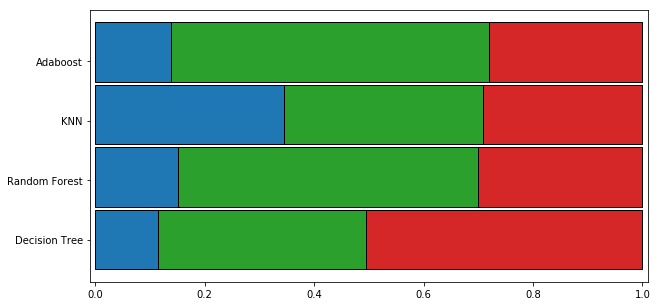

In [55]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
cmap=matplotlib.colors.ListedColormap(['C0','C2','C3'],N=3)
for i,d in enumerate([data_dt, data_rf, data_knn, data_adaboost]):
    ax.barh(i*1.05,d[d == 0].shape[0]/d.shape[0],color=cmap.colors[0],height=1,edgecolor='k')
    ax.barh(i*1.05,d[d == 1].shape[0]/d.shape[0],left=d[d == 0].shape[0]/d.shape[0],color=cmap.colors[1],height=1,edgecolor='k')
    ax.barh(i*1.05,d[d == 2].shape[0]/d.shape[0],left=d[d != 2].shape[0]/d.shape[0],color=cmap.colors[2],height=1,edgecolor='k')
#Labels, Ticks, etc
ax.set_xlim(-0.01,1.01)
ax.set_yticks([0,1,2,3],)
ax.set_yticklabels(('Decision Tree', 'Random Forest', 'KNN', 'Adaboost'))